# CommonLit - Evaluate Student Summaries Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the **CommonLit - Evaluate Student Summaries** dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [1]:
import string
import re
import numpy as np
import pandas as pd
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
#import os added
import os

In [2]:
'''print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)'''

'print("TensorFlow v" + tf.__version__)\nprint("TensorFlow Decision Forests v" + tfdf.__version__)'

# Load the Dataset

### Load the prompt csv

**Avant**

In [3]:
#df_train_prompt = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
#print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

**Après**

In [4]:
#creating a variable for the path of the data folder
path_data = './commonlit-evaluate-student-summaries/'
#listing the files in the data folder
print(os.listdir(path_data))
df_train_prompt = pd.read_csv(path_data+'prompts_train.csv')

['summaries_test.csv', 'sample_submission.csv:Zone.Identifier', 'summaries_train.csv', 'summaries_train.csv:Zone.Identifier', 'sample_submission.csv', 'prompts_train.csv:Zone.Identifier', 'prompts_test.csv:Zone.Identifier', 'prompts_test.csv', 'prompts_train.csv', 'summaries_test.csv:Zone.Identifier']


In [5]:
print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

Full prompt train dataset shape is (4, 4)


In [6]:
df_train_prompt.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


The data is composed of 4 columns and 4 entries. We can see all 4 dimensions of our dataset by using the following code:

### Load the summaries csv

In [7]:
#Avant
#df_train_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
#print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

#Après
df_train_summaries = pd.read_csv(path_data+'summaries_train.csv')
print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

Full summaries train dataset shape is (7165, 5)


The data is composed of 5 columns and 7165 entries. We can see all 5 dimensions of our dataset by printing out the first 5 entries using the following code:

In [8]:
df_train_summaries.head(5)

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Combine both summaries and prompt csv's based on prompt id

In [9]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')
print("Full summaries train dataset shape is {}".format(df_train.shape))

Full summaries train dataset shape is (7165, 8)


The data is composed of 8 columns and 7165 entries. We can see all 8 dimensions of our dataset by printing out the first 5 entries using the following code:

In [10]:
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


# Quick basic dataset exploration

In [11]:
df_train_summaries.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [12]:
df_train_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


# Label data distribution

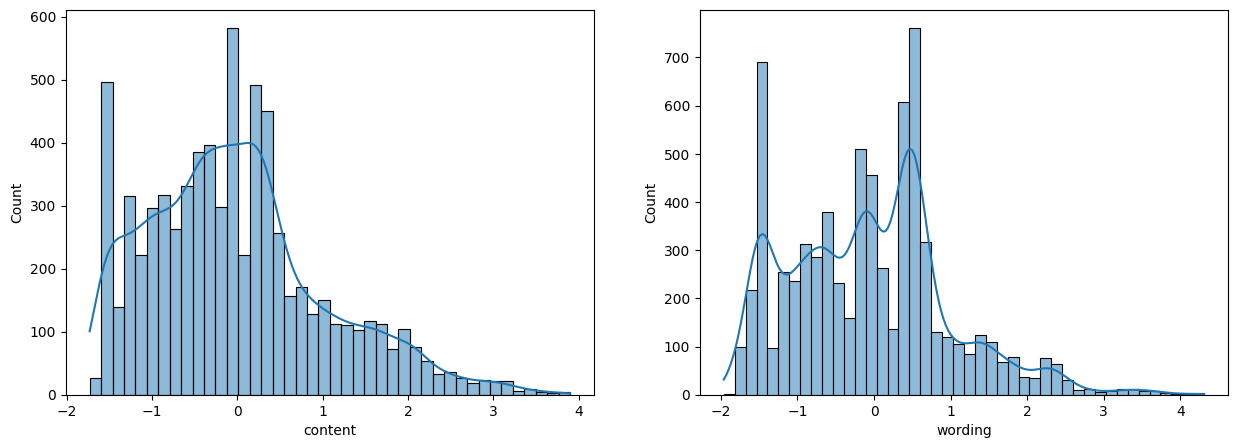

In [13]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train_summaries, x='content', kde=True)
plt.subplot(1, 2, 2)
sns.histplot(data=df_train_summaries, x='wording', kde=True)
plt.show()

In [14]:
#check in which measure content and wording are correlated
df_train_summaries.corr()

,content,wording
content,1.00000,0.75138
wording,0.75138,1.00000


<AxesSubplot:xlabel='content', ylabel='wording'>

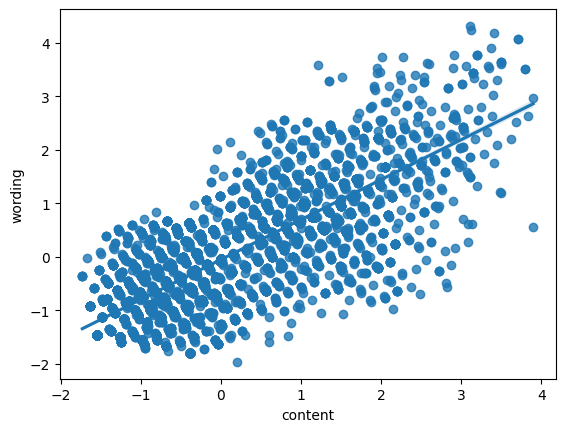

In [15]:
sns.regplot(data=df_train_summaries, x='content', y='wording')

# LLM vs Non-LLM solutions

In this notebook, we won't be using an LLM model to embedd the text features. Instead we will calculate some numeric features from the text features like token count, length etc. Using these numeric features, we can create tabular data that can be used train our Model. This approach shows that sometimes non-LLM solutions can also give good results.   

# Preprocess the data

In [16]:
# Reference: https://www.kaggle.com/code/sercanyesiloz/commonlit-tf-idf-xgb-baseline#4.-Feature-Engineering

# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, 
# both when indexing entries for searching and when retrieving them as the result of a search query.
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    dataframe[f'{feature}_stopword_cnt_relative'] = dataframe[f'{feature}_stopword_cnt'] / dataframe[f'{feature}_word_cnt']
    dataframe[f'{feature}_punct_cnt_relative'] = dataframe[f'{feature}_punct_cnt'] / dataframe[f'{feature}_word_cnt']
    return dataframe

# Adding features from the feature_engineer function

In [17]:
df_train_summaries = feature_engineer(df_train_summaries)
print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

Full summaries train dataset shape is (7165, 12)


## Let's check the correlation between the features and the targets

In [18]:
#check in which measure variable are correlated
df_train_summaries.corr()

,content,wording,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt,text_stopword_cnt_relative,text_punct_cnt_relative
content,1.000000,0.751380,0.785671,0.797244,0.778149,0.670398,0.296109,-0.055663,0.190225
wording,0.751380,1.000000,0.531540,0.540138,0.538102,0.396094,0.162928,0.007854,0.038480
text_word_cnt,0.785671,0.531540,1.000000,0.989033,0.977554,0.848050,0.383635,-0.046652,0.179682
text_length,0.797244,0.540138,0.989033,1.000000,0.972962,0.870013,0.388909,-0.061246,0.214782
text_stopword_cnt,0.778149,0.538102,0.977554,0.972962,1.000000,0.806981,0.347115,0.109263,0.130804
text_punct_cnt,0.670398,0.396094,0.848050,0.870013,0.806981,1.000000,0.444333,-0.161817,0.571853
text_number_cnt,0.296109,0.162928,0.383635,0.388909,0.347115,0.444333,1.000000,-0.146788,0.247722
text_stopword_cnt_relative,-0.055663,0.007854,-0.046652,-0.061246,0.109263,-0.161817,-0.146788,1.000000,-0.308984
text_punct_cnt_relative,0.190225,0.038480,0.179682,0.214782,0.130804,0.571853,0.247722,-0.308984,1.000000


One can notice that many features enginneer such as text_length, text_word_cnt, text_stopword_cnt, text_punt_cnt, are strongly autocorrelated. Through there is a strong redundancy accross these features in explaining content and wording variability. Accordingly, it would be wise to only keep the best feature among them, which is the text_length based on the correlation coefficient display in the matrix above.

Others columns can be drop...

In [19]:
#drop the columns that are not needed, text_word_cnt, text_stopword_cnt, text_punct_cnt, text_number_cnt
df_train_summaries = df_train_summaries.drop(['text_word_cnt', 'text_stopword_cnt', 'text_punct_cnt', 'text_number_cnt'], axis=1)
#we create a dictionary with the prompt_id as key and the prompt lenght as value
prompt_dict = dict(zip(df_train_prompt.prompt_id, df_train_prompt.prompt_text.apply(lambda x: len(x))))
#we create a new column in the df_train_summaries dataframe with the prompt lenght
df_train_summaries['prompt_length'] = df_train_summaries.prompt_id.map(prompt_dict)
#we create a colums with the ratio of the content lenght over the prompt lenght
df_train_summaries['summary_prompt_ratio'] = df_train_summaries.text_length / df_train_summaries.prompt_length
#check in which measure variable are correlated
df_train_summaries.corr()

,content,wording,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio
content,1.000000,0.751380,0.797244,-0.055663,0.190225,-0.038325,0.777707
wording,0.751380,1.000000,0.540138,0.007854,0.038480,-0.121424,0.546898
text_length,0.797244,0.540138,1.000000,-0.061246,0.214782,0.001612,0.961734
text_stopword_cnt_relative,-0.055663,0.007854,-0.061246,1.000000,-0.308984,-0.101013,-0.049438
text_punct_cnt_relative,0.190225,0.038480,0.214782,-0.308984,1.000000,0.039827,0.201528
prompt_length,-0.038325,-0.121424,0.001612,-0.101013,0.039827,1.000000,-0.219400
summary_prompt_ratio,0.777707,0.546898,0.961734,-0.049438,0.201528,-0.219400,1.000000


# NLP prepocessing

We can expect the reuse of words from the prompt to be a good proxy for evaluating the content score of a summary. By the way, this equal to measuring distance between community in ecology (i.e. beta diversity). Similar information should also instil from the prompt_question to the summary. The distance/similarity from the initial prompt_text should be taken into account for this task. Since the occurence of given words is what really matter here, rather than their relative abundance, we can use the Jaccard similarity metric on preprocessed/tokenized text, prompt_text, and prompt_question. 

#### NLP pre-processing step 1 > remove punctuation from text and prompt ####

In [20]:
import string
ls_punct = string.punctuation
#remove punctuation from text using the below function
def remove_ponctuation(text, ls_punct):
    for punct in ls_punct:
        text = text.replace(punct,'')
    return text

In [21]:
df_train_summaries['text_cleaned'] = df_train_summaries['text'].apply(lambda x: remove_ponctuation(x, ls_punct))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text'].apply(lambda x: remove_ponctuation(x, ls_punct))
df_train_prompt['prompt_question_cleaned'] = df_train_prompt['prompt_question'].apply(lambda x: remove_ponctuation(x, ls_punct))

#### NLP pre-processing step 2 > remove uppercase

In [22]:
df_train_summaries['text_cleaned'] = df_train_summaries['text_cleaned'].apply(lambda x: x.lower())
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: x.lower())
df_train_prompt['prompt_question_cleaned'] = df_train_prompt['prompt_question_cleaned'].apply(lambda x: x.lower())

In [23]:
df_train_prompt

,prompt_id,prompt_question,prompt_title,prompt_text,prompt_text_cleaned,prompt_question_cleaned
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,chapter 13 \r\nas the sequel to what has alrea...,summarize at least 3 elements of an ideal trag...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,egyptian society was structured like a pyramid...,in complete sentences summarize the structure ...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,background \r\nthe third wave experiment took ...,summarize how the third wave developed over su...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",with one member trimming beef in a cannery and...,summarize the various ways the factory would u...


#### NLP pre-processing step 3 > suppress digits

In [24]:
digits = [str(i) for i in list(range(10))]
def remove_numb(text):
    for numb in digits:
        text = text.replace(numb,'')
    return text

In [25]:
df_train_summaries['text_cleaned'] = df_train_summaries['text_cleaned'].apply(lambda x: remove_numb(x))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: remove_numb(x))
df_train_prompt['prompt_question_cleaned'] = df_train_prompt['prompt_question_cleaned'].apply(lambda x: remove_numb(x))

#### NLP pre-processing 4 > making list of sentences

In [26]:
#we create a function that split the text into sentences
def split_sentences(text):
    text = remove_numb(text.lower())
    return text.split('.')

#we create a new column with the sentences
df_train_summaries['text_sentences'] = df_train_summaries['text'].apply(lambda x: split_sentences(x))

In [27]:
df_train_summaries['text_sentences'].loc[0]

['the third wave was an experimentto see how people reacted to a new one leader government',
 ' it gained popularity as people wanted to try new things',
 ' the students follow anything that is said and start turning on eachother to gain higher power',
 ' they had to stop the experement as too many people got to radical with it blindly following there leader']

#### NLP pre-processing step 5 > extracting word's tags from non-lemmatized text 

In [28]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/jerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jerome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jerome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jerome/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
#we create a function that iterates over the non-lemmatized text and extract the tags of the words using the nltk.pos_tag function
#we return a list of tags
def extract_tags(text):
    tags = []
    for word in word_tokenize(text):
        tags.append(nltk.pos_tag([word])[0][1])
    return tags

df_train_summaries['text_tags'] = df_train_summaries['text_cleaned'].apply(lambda x: extract_tags(x))

In [30]:
#we create a function that iterates over the text_tags and add the tags if not in a tags list
#we return a list of tags
def make_tags_list(text_tags, tags_list):
    for tag in text_tags:
        if tag not in tags_list:
            tags_list.append(tag)
    return tags_list

#we apply the function to the text_tags column and return a list of tags
tags_list = []
for i in df_train_summaries['text_tags'].tolist():
    tags_list = make_tags_list(i, tags_list)

In [31]:
print(tags_list)

['DT', 'JJ', 'NN', 'VBD', 'VB', 'WRB', 'NNS', 'VBN', 'TO', 'CD', 'PRP', 'IN', 'VBZ', 'CC', 'VBG', 'JJR', 'RB', 'MD', 'PRP$', 'WP', 'RBR', 'JJS', 'WDT', 'VBP', 'WP$']


#### NLP pre_processing step 6 > extracting bigrams, trigrams, and four grams tags from sentences

In [32]:
#we create a function that iterates over the text_sentences and return the associated tags using nltk pos_tag function
def extract_tags_sentences(text_sentences):
    tags_sentences = []
    for sentence in text_sentences:
        tok_sentence = word_tokenize(sentence)
        list_tags = []
        for word in tok_sentence:
            list_tags.append(nltk.pos_tag([word])[0][1])
        tags_sentences.append(list_tags)
    return tags_sentences

#we create a new column with the tags of the sentences
df_train_summaries['text_sentences_tags'] = df_train_summaries['text_sentences'].apply(lambda x: extract_tags_sentences(x))

In [33]:
#we create a function that return ngrams from text_sentences_tags using the ngrams function from nltk
def make_ngrams(text_sentences_tags, n):
    list_ngrams = []
    for sentence in text_sentences_tags:
        res = list(nltk.ngrams(sentence, n))
        list_ngrams += res
    return list_ngrams
    
#we apply the function to the text_sentences_tags column and return a list of bigrams
#df_train_summaries['text_bigrams'] = df_train_summaries['text_sentences_tags'].apply(lambda x: make_ngrams(x, 2))
#we apply the function to the text_sentences_tags column and return a list of trigrams
#df_train_summaries['text_trigrams'] = df_train_summaries['text_sentences_tags'].apply(lambda x: make_ngrams(x, 3))
# we apply the function to the text_sentences_tags column and return a list of 4-grams
df_train_summaries['text_4grams'] = df_train_summaries['text_sentences_tags'].apply(lambda x: make_ngrams(x, 4))
# we apply the function to the text_sentences_tags column and return a list of 5-grams
#df_train_summaries['text_5grams'] = df_train_summaries['text_sentences_tags'].apply(lambda x: make_ngrams(x, 5))

In [34]:
df_train_summaries

,student_id,prompt_id,text,content,wording,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio,text_cleaned,text_sentences,text_tags,text_sentences_tags,text_4grams
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346,0.409836,0.049180,3566,0.097027,the third wave was an experimentto see how peo...,[the third wave was an experimentto see how pe...,"[DT, JJ, NN, VBD, DT, NN, VB, WRB, NNS, VBN, T...","[[DT, JJ, NN, VBD, DT, NN, VB, WRB, NNS, VBN, ...","[(DT, JJ, NN, VBD), (JJ, NN, VBD, DT), (NN, VB..."
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,244,0.576923,0.038462,5136,0.047508,they would rub it up with soda to make the sme...,[they would rub it up with soda to make the sm...,"[PRP, MD, NN, PRP, RB, IN, NN, TO, VB, DT, NN,...","[[PRP, MD, NN, PRP, RB, IN, NN, TO, VB, DT, NN...","[(PRP, MD, NN, PRP), (MD, NN, PRP, RB), (NN, P..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1370,0.417021,0.161702,3345,0.409567,in egypt there were many occupations and socia...,"[in egypt, there were many occupations and soc...","[IN, NN, RB, VBD, JJ, NNS, CC, JJ, NNS, VBN, I...","[[IN, NN, ,, RB, VBD, JJ, NNS, CC, JJ, NNS, VB...","[(IN, NN, ,, RB), (NN, ,, RB, VBD), (,, RB, VB..."
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,157,0.440000,0.240000,3345,0.046936,the highest class was pharaohs these people we...,[the highest class was pharaohs these people w...,"[DT, JJS, NN, VBD, NN, DT, NNS, VBD, NN, DT, N...","[[DT, JJS, NN, VBD, NN, DT, NNS, VBD, NNS], [R...","[(DT, JJS, NN, VBD), (JJS, NN, VBD, NN), (NN, ..."
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225,0.446602,0.145631,3566,0.343522,the third wave developed rapidly because the ...,[the third wave developed rapidly because the...,"[DT, JJ, NN, NN, RB, IN, DT, NNS, RB, VBN, IN,...","[[DT, JJ, NN, NN, RB, IN, DT, NNS, RB, VBN, IN...","[(DT, JJ, NN, NN), (JJ, NN, NN, RB), (NN, NN, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,357,0.507463,0.149254,5136,0.069509,they used all sorts of chemical concoctions to...,[they used all sorts of chemical concoctions t...,"[PRP, VBN, DT, NNS, IN, NN, NNS, TO, VB, DT, N...","[[PRP, VBN, DT, NNS, IN, NN, NNS, TO, VB, DT, ...","[(PRP, VBN, DT, NNS), (VBN, DT, NNS, IN), (DT,..."
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,255,0.409091,0.159091,3345,0.076233,the lowest classes are slaves and farmers slav...,[the lowest classes are slaves and farmers sla...,"[DT, JJS, NNS, VBP, NNS, CC, NNS, NNS, VBG, NN...","[[DT, JJS, NNS, VBP, NNS, CC, NNS, NNS, VBG, N...","[(DT, JJS, NNS, VBP), (JJS, NNS, VBP, NNS), (N..."
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,272,0.271186,0.084746,3345,0.081315,they sorta made people start workin...,[ they sorta made people start worki...,"[PRP, NN, VBN, NNS, NN, VBG, IN, DT, NN, NNS, ...","[[PRP, NN, VBN, NNS, NN, VBG, IN, DT, NN, NNS,...","[(PRP, NN, VBN, NNS), (NN, VBN, NNS, NN), (VBN..."
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,294,0.457627,0.067797,3364,0.087396,an ideal tragety has three elements that make ...,[an ideal tragety has three elements that make...,"[DT, NN, NN, VBZ, CD, NNS, IN, VB, PRP, NN, TO...","[[DT, NN, NN, VBZ, CD, NNS, IN, VB, PRP, NN], ...","[(DT, NN, NN, VBZ), (NN, NN, VBZ, CD), (NN, VB..."


#### NLP pre-processing step 7 > suppress stopwords and tokenized the text and prompt_text

In [35]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /home/jerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jerome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jerome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jerome/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [36]:
#create a function to remove stopwords from text and prompt_text
#!!!this step also tokenizes the text!!!
stpw = tuple(stopwords.words('english'))

def remove_stopwords(text, stpw):
    output = [i for i in word_tokenize(text) if i not in stpw]
    return output

In [37]:
df_train_summaries['text_cleaned'] = df_train_summaries['text_cleaned'].apply(lambda x: remove_stopwords(x, stpw))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: remove_stopwords(x, stpw))
df_train_prompt['prompt_question_cleaned'] = df_train_prompt['prompt_question_cleaned'].apply(lambda x: remove_stopwords(x, stpw))

#### NLP pre-processing step 8 > Lemmatize text and prompt_text

In [38]:
from nltk.stem import WordNetLemmatizer

In [39]:
#create a function to lemmatize the text and remove words with length less than 2
#return the text as a string
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

dict_tags = {'verb': ['VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'],
             'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
             'adj': ['JJ', 'JJR', 'JJS']}

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    output = []
    for word in text:
        if len(word) > 2:
            if nltk.pos_tag([word])[0][1] in dict_tags['verb']:
                output.append(lemmatizer.lemmatize(word, pos='v')) #we use pos='v' to lemmatize verbs
            elif nltk.pos_tag([word])[0][1] in dict_tags['noun']:
                output.append(lemmatizer.lemmatize(word, pos='n')) #we use pos='n' to lemmatize nouns
            elif nltk.pos_tag([word])[0][1] in dict_tags['adj']:
                output.append(lemmatizer.lemmatize(word, pos='a')) #we use pos='a' to lemmatize adjectives
            else:
                output.append(lemmatizer.lemmatize(word))
    return ' '.join(output)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jerome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jerome/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
df_train_summaries['text_cleaned'] = df_train_summaries['text_cleaned'].apply(lambda x: lemmatize_text(x))
df_train_prompt['prompt_text_cleaned'] = df_train_prompt['prompt_text_cleaned'].apply(lambda x: lemmatize_text(x))
df_train_prompt['prompt_question_cleaned'] = df_train_prompt['prompt_question_cleaned'].apply(lambda x: lemmatize_text(x))

In [41]:
print(df_train_summaries['text_cleaned'].loc[0])

third wave experimentto see people react new one leader government gain popularity people want try new thing student follow anything say start turn eachother gain high power stop experement many people get radical blindly follow leader


#### NLP pre-processing step 9 > Transform texts in count vectorized matrix. 
##### Since the goal is to calculate a jaccard similarity between text and prompt_text, the count_vectorization is dependant upon the prompt_id. 

In [42]:
#import the TfidfVectorizer
#this will be used to convert text to numbers
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
#let check whether the student_id is unique
print(f'the dimmension of df_train are {df_train_summaries.shape}')
print(f"the number of unique student_id is {len(df_train_summaries['student_id'].unique().tolist())}")
#ok the number of row in df_train is equal to the number of unique student_id, then we can use student_id as key for further merge

the dimmension of df_train are (7165, 15)
the number of unique student_id is 7165


In [44]:
#we need to create a dictionnaries were trained and transformed Countvectorizers will be stored for each prompt_id
#this will be used to transform the test dataset respective to each prompt_id
prompt_id = df_train_prompt['prompt_id'].unique().tolist()

CountVectorizer_fitted_prompt_dict = {}
CountVectorizer_transformed_prompt_dict = {}
for item in prompt_id:
    vectorizer = CountVectorizer(max_features=50)
    X = vectorizer.fit(df_train_prompt.prompt_text_cleaned.loc[df_train_prompt.prompt_id == item])
    CountVectorizer_fitted_prompt_dict[item] = X
    CountVectorizer_transformed_prompt_dict[item] = X.transform(df_train_prompt.prompt_text_cleaned.loc[df_train_prompt.prompt_id == item])
    
CountVectorizer_fitted_question_dict = {}
CountVectorizer_transformed_question_dict = {}
for item in prompt_id:
    vectorizer = CountVectorizer(max_features=30)
    X = vectorizer.fit(df_train_prompt.prompt_question_cleaned.loc[df_train_prompt.prompt_id == item])
    CountVectorizer_fitted_question_dict[item] = X
    CountVectorizer_transformed_question_dict[item] = X.transform(df_train_prompt.prompt_question_cleaned.loc[df_train_prompt.prompt_id == item])

In [45]:
#we create a function to transform the text to numbers using the trained CountVectorizers
#we use the prompt_id to select the right CountVectorizer
#we return the transformed text as a numpy array
#we also return the CountVectorizer used to transform the text
#we transform the text to a numpy array and changed it to binary data to be able to use it in the Jaccard similarity function
#then we return the Jaccard similarity between the text and the prompt_text
from sklearn.metrics import jaccard_score

def calculate_Jaccard_dist(text, prompt_id, fitted_dict, transformed_dict):
    vectorizer = fitted_dict[prompt_id]
    text_transformed = vectorizer.transform([text]).toarray()
    prompt_text_transformed = transformed_dict[prompt_id].toarray()
    txt = np.array([i if i == 0 else 1 for i in text_transformed.tolist()[0]])
    prompt = np.array([i if i == 0 else 1 for i in prompt_text_transformed.tolist()[0]])  
    return jaccard_score(txt, prompt)

In [46]:
#we apply the function to the train dataset
df_train_summaries['Jaccard_prompt_to_text'] = df_train_summaries.apply(lambda x: calculate_Jaccard_dist(x['text_cleaned'], x['prompt_id'], CountVectorizer_fitted_prompt_dict, CountVectorizer_transformed_prompt_dict), axis=1)
df_train_summaries['Jaccard_question_to_text'] = df_train_summaries.apply(lambda x: calculate_Jaccard_dist(x['text_cleaned'], x['prompt_id'], CountVectorizer_fitted_question_dict, CountVectorizer_transformed_question_dict), axis=1)

<AxesSubplot:xlabel='Jaccard_question_to_text', ylabel='Count'>

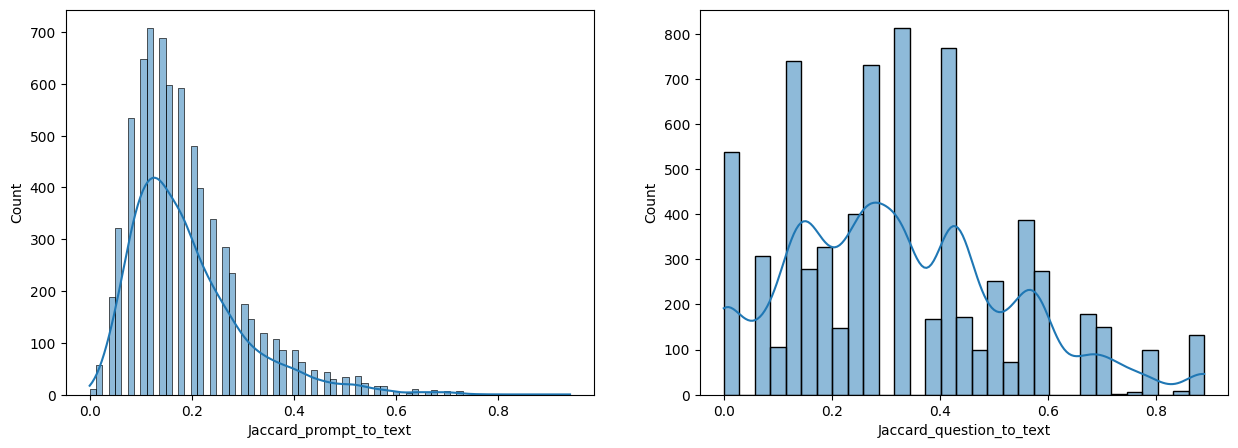

In [47]:
#we check the distribution of the Jaccard_dist
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train_summaries, x='Jaccard_prompt_to_text', kde=True)
plt.subplot(1, 2, 2)
sns.histplot(data=df_train_summaries, x='Jaccard_question_to_text', kde=True)

In [48]:
prompt_id

['39c16e', '3b9047', '814d6b', 'ebad26']

In [49]:
#make a plot function to check the correlation between a given feature and the targets
def plot_feature_corr(df_train_summaries, feature):
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_train_summaries, x=feature, y='content', hue='prompt_id', alpha=0.5)
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[0]], x=feature, y='content', scatter=False, color='red')
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[1]], x=feature, y='content', scatter=False, color='green')
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[2]], x=feature, y='content', scatter=False, color='orange')
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[3]], x=feature, y='content', scatter=False, color='blue')
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_train_summaries, x=feature, y='wording', hue='prompt_id', alpha=0.5)
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[0]], x=feature, y='wording', scatter=False, color='red')
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[1]], x=feature, y='wording', scatter=False, color='green')
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[2]], x=feature, y='wording', scatter=False, color='orange')
    sns.regplot(data=df_train_summaries.loc[df_train_summaries['prompt_id'] == prompt_id[3]], x=feature, y='wording', scatter=False, color='blue')
    plt.show()

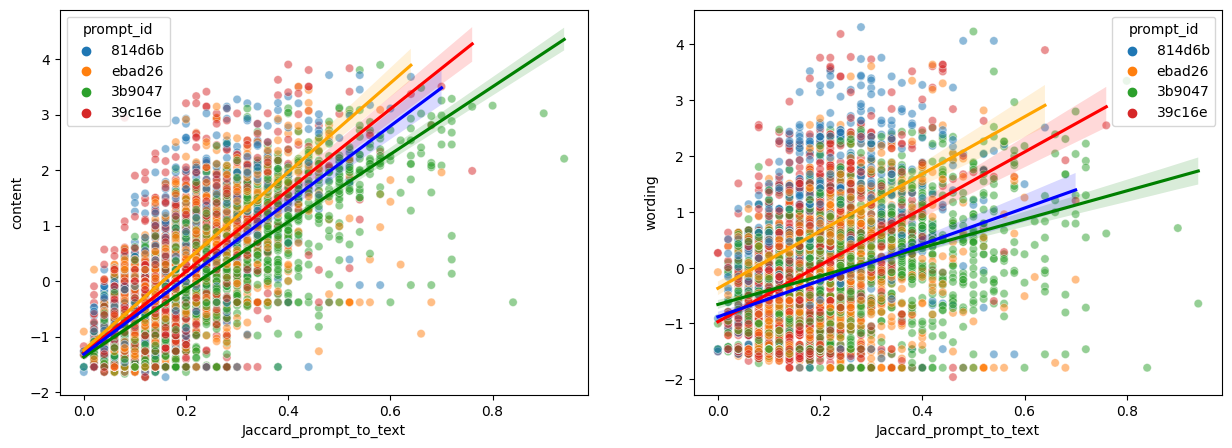

In [50]:
#we check for correlation between the 'Jaccard_prompt_to_text' and the targets
plot_feature_corr(df_train_summaries, 'Jaccard_prompt_to_text')

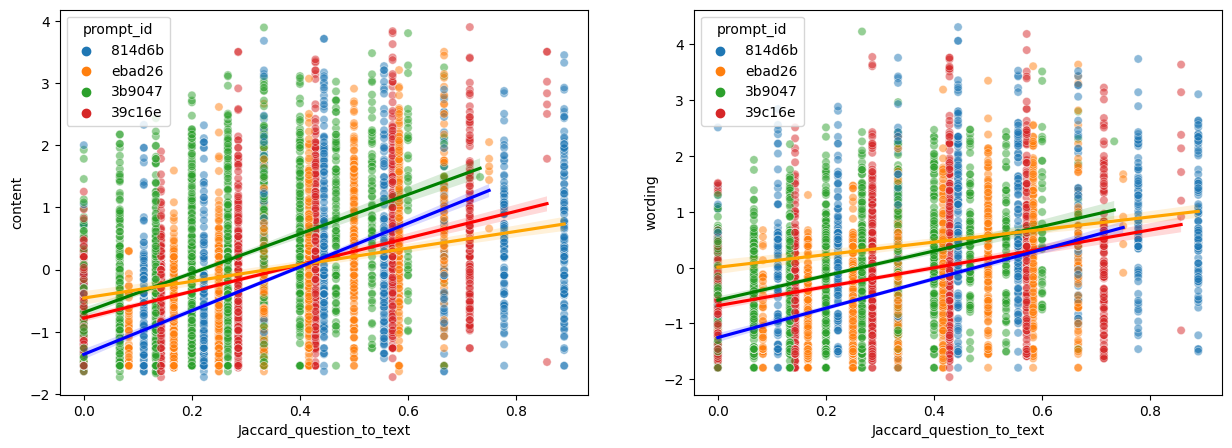

In [51]:
#we check for correlation between the 'Jaccard_question_to_text' and the targets
plot_feature_corr(df_train_summaries, 'Jaccard_question_to_text')

In [52]:
df_train_summaries

,student_id,prompt_id,text,content,wording,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio,text_cleaned,text_sentences,text_tags,text_sentences_tags,text_4grams,Jaccard_prompt_to_text,Jaccard_question_to_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346,0.409836,0.049180,3566,0.097027,third wave experimentto see people react new o...,[the third wave was an experimentto see how pe...,"[DT, JJ, NN, VBD, DT, NN, VB, WRB, NNS, VBN, T...","[[DT, JJ, NN, VBD, DT, NN, VB, WRB, NNS, VBN, ...","[(DT, JJ, NN, VBD), (JJ, NN, VBD, DT), (NN, VB...",0.12,0.222222
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,244,0.576923,0.038462,5136,0.047508,would rub soda make smell away wouldnt bad sme...,[they would rub it up with soda to make the sm...,"[PRP, MD, NN, PRP, RB, IN, NN, TO, VB, DT, NN,...","[[PRP, MD, NN, PRP, RB, IN, NN, TO, VB, DT, NN...","[(PRP, MD, NN, PRP), (MD, NN, PRP, RB), (NN, P...",0.08,0.166667
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1370,0.417021,0.161702,3345,0.409567,egypt many occupation social class involve day...,"[in egypt, there were many occupations and soc...","[IN, NN, RB, VBD, JJ, NNS, CC, JJ, NNS, VBN, I...","[[IN, NN, ,, RB, VBD, JJ, NNS, CC, JJ, NNS, VB...","[(IN, NN, ,, RB), (NN, ,, RB, VBD), (,, RB, VB...",0.50,0.266667
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,157,0.440000,0.240000,3345,0.046936,high class pharaoh people godsthen high class ...,[the highest class was pharaohs these people w...,"[DT, JJS, NN, VBD, NN, DT, NNS, VBD, NN, DT, N...","[[DT, JJS, NN, VBD, NN, DT, NNS, VBD, NNS], [R...","[(DT, JJS, NN, VBD), (JJS, NN, VBD, NN), (NN, ...",0.08,0.066667
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225,0.446602,0.145631,3566,0.343522,third wave developed rapidly student genuinly ...,[the third wave developed rapidly because the...,"[DT, JJ, NN, NN, RB, IN, DT, NNS, RB, VBN, IN,...","[[DT, JJ, NN, NN, RB, IN, DT, NNS, RB, VBN, IN...","[(DT, JJ, NN, NN), (JJ, NN, NN, RB), (NN, NN, ...",0.30,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538,357,0.507463,0.149254,5136,0.069509,use sort chemical concoction make meat seem fi...,[they used all sorts of chemical concoctions t...,"[PRP, VBN, DT, NNS, IN, NN, NNS, TO, VB, DT, N...","[[PRP, VBN, DT, NNS, IN, NN, NNS, TO, VB, DT, ...","[(PRP, VBN, DT, NNS), (VBN, DT, NNS, IN), (DT,...",0.12,0.166667
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171,255,0.409091,0.159091,3345,0.076233,low class slave farmer slave people take war f...,[the lowest classes are slaves and farmers sla...,"[DT, JJS, NNS, VBP, NNS, CC, NNS, NNS, VBG, NN...","[[DT, JJS, NNS, VBP, NNS, CC, NNS, NNS, VBG, N...","[(DT, JJS, NNS, VBP), (JJS, NNS, VBP, NNS), (N...",0.18,0.066667
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603,272,0.271186,0.084746,3345,0.081315,sorta make people start work structour theyed ...,[ they sorta made people start worki...,"[PRP, NN, VBN, NNS, NN, VBG, IN, DT, NN, NNS, ...","[[PRP, NN, VBN, NNS, NN, VBG, IN, DT, NN, NNS,...","[(PRP, NN, VBN, NNS), (NN, VBN, NNS, NN), (VBN...",0.18,0.000000
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128,294,0.457627,0.067797,3364,0.087396,ideal tragety three element make ideal start g...,[an ideal tragety has three elements that make...,"[DT, NN, NN, VBZ, CD, NNS, IN, VB, PRP, NN, TO...","[[DT, NN, NN, VBZ, CD, NNS, IN, VB, PRP, NN], ...","[(DT, NN, NN, VBZ), (NN, NN, VBZ, CD), (NN, VB...",0.16,0.428571


# Accessing the diversity of words within texts
We used beta diversity (i.e. Jaccard similarity) to access the distance between text and prompt_text and prompt_question. We can use an alpha diversity metrics (i.e. which measure the diversity of words within each text) to access the diversity of words used by students in their summaries. We can hypothesized that the more diverse the vocabulary, the better the wording score is, albeit this should be verified... The Shannon's diversity index can be used to perform beta diversity measure.  

In [53]:
#the function below is used to calculate the Shannon Diversity Index from a list of proportions
#the list can be obtaine using the countvectorizer fit_transform function for each text
import math

def shannon_diversity_index(text):
    #we count a words from the text
    vectorizer = CountVectorizer()
    counts = vectorizer.fit_transform([text]).toarray()[0]
    proportions = [i/sum(counts) for i in counts]
    # Calculate the Shannon Diversity Index
    shannon_index = -sum(p * math.log(p) for p in proportions)
    return shannon_index

<AxesSubplot:xlabel='shannon_diversity_index', ylabel='Count'>

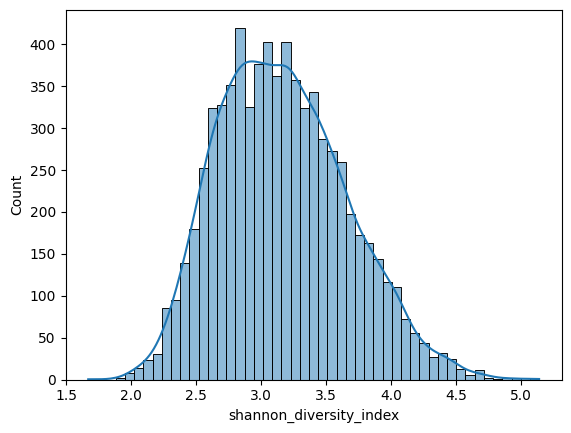

In [54]:
#we apply the function to the text in the df_train_summaries dataframe
df_train_summaries['shannon_diversity_index'] = df_train_summaries['text_cleaned'].apply(lambda x: shannon_diversity_index(x))
#we check the distribution of the shannon_diversity_index
sns.histplot(data=df_train_summaries, x='shannon_diversity_index', kde=True)

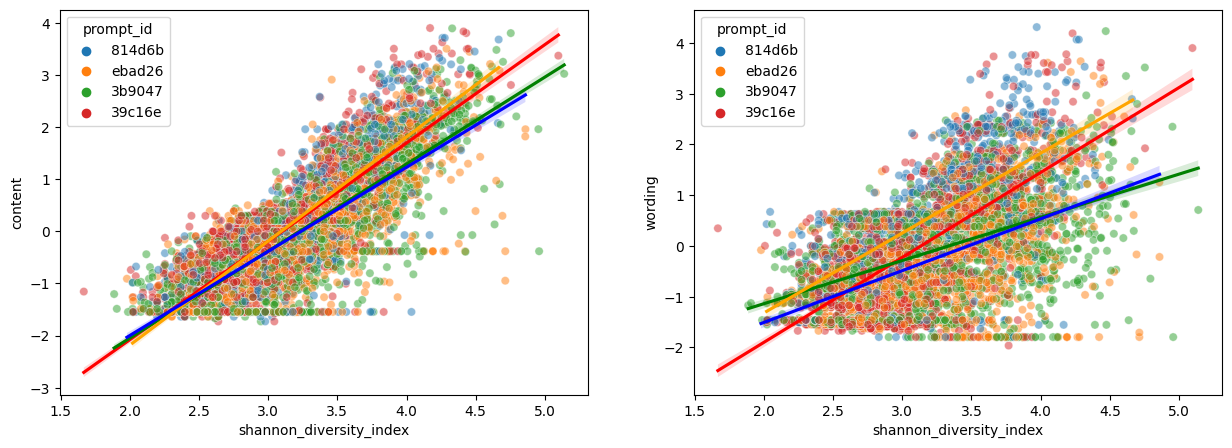

In [55]:
#we check for correlation between the Shannon Diversity Index and the targets
plot_feature_corr(df_train_summaries, 'shannon_diversity_index')

In [56]:
#transform the shannon_diversity_index exponentially
df_train_summaries['shannon_diversity_index_exp'] = df_train_summaries['shannon_diversity_index'].apply(lambda x: math.exp(x))

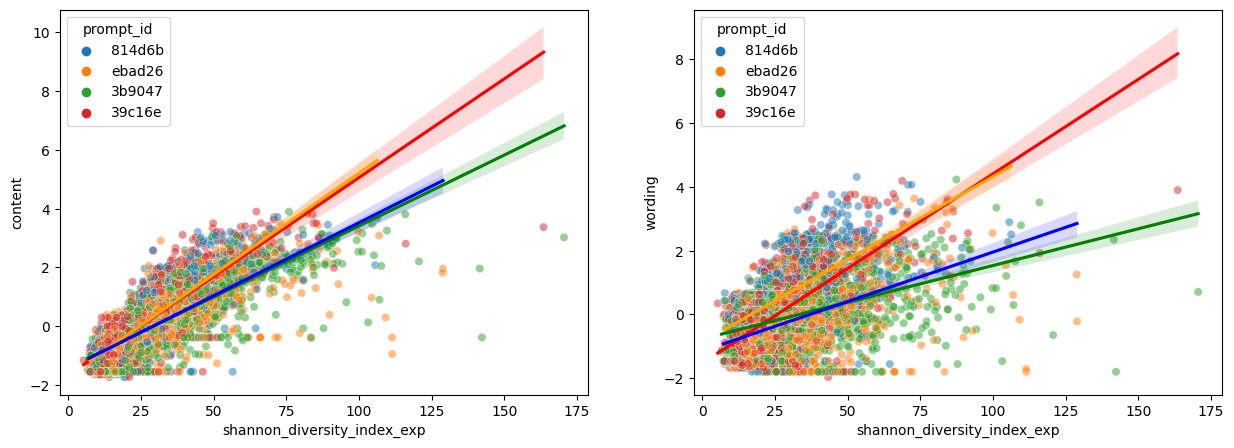

In [57]:
#we check for correlation between the exponentially transformed Shannon Diversity Index and the targets
plot_feature_corr(df_train_summaries, 'shannon_diversity_index_exp')

In [58]:
#check in which measure variable are correlated
df_train_summaries.corr()

,content,wording,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio,Jaccard_prompt_to_text,Jaccard_question_to_text,shannon_diversity_index,shannon_diversity_index_exp
content,1.000000,0.751380,0.797244,-0.055663,0.190225,-0.038325,0.777707,0.691462,0.410550,0.815435,0.783715
wording,0.751380,1.000000,0.540138,0.007854,0.038480,-0.121424,0.546898,0.353051,0.356157,0.552664,0.506515
text_length,0.797244,0.540138,1.000000,-0.061246,0.214782,0.001612,0.961734,0.820419,0.334869,0.867539,0.950278
text_stopword_cnt_relative,-0.055663,0.007854,-0.061246,1.000000,-0.308984,-0.101013,-0.049438,-0.118150,-0.079466,-0.180916,-0.138299
text_punct_cnt_relative,0.190225,0.038480,0.214782,-0.308984,1.000000,0.039827,0.201528,0.264516,0.019438,0.242000,0.231729
prompt_length,-0.038325,-0.121424,0.001612,-0.101013,0.039827,1.000000,-0.219400,-0.061386,0.134586,0.024728,0.014990
summary_prompt_ratio,0.777707,0.546898,0.961734,-0.049438,0.201528,-0.219400,1.000000,0.812106,0.285349,0.826982,0.911248
Jaccard_prompt_to_text,0.691462,0.353051,0.820419,-0.118150,0.264516,-0.061386,0.812106,1.000000,0.246401,0.818659,0.853341
Jaccard_question_to_text,0.410550,0.356157,0.334869,-0.079466,0.019438,0.134586,0.285349,0.246401,1.000000,0.369502,0.321969
shannon_diversity_index,0.815435,0.552664,0.867539,-0.180916,0.242000,0.024728,0.826982,0.818659,0.369502,1.000000,0.942914


# Accessing the number of word in text that is not in the prompt_text 

The use of word other then the ones that are in the prompt might inform about the vocabulary of the student and thus might help predicting the wording score

In [59]:
#create a function that check whether a word from the text is not in the prompt_text
#we return the number of words from the text that not are in the prompt_text
def check_words_not_in_prompt(text, prompt_id, df_train_prompt):
    prompt_text = df_train_prompt.prompt_text_cleaned.loc[df_train_prompt.prompt_id == prompt_id].tolist()[0].split(' ')
    text = text.split(' ')
    count = 0
    for word in text:
        if word not in prompt_text:
            count += 1
    return count

def list_words_not_in_prompt(text, prompt_id, df_train_prompt):
    prompt_text = df_train_prompt.prompt_text_cleaned.loc[df_train_prompt.prompt_id == prompt_id].tolist()[0].split(' ')
    text = text.split(' ')
    list = []
    for word in text:
        if word not in prompt_text:
            list.append(word)
    return list

In [60]:
#we apply the functions to the df_train_summary dataset
df_train_summaries['words_not_in_prompt'] = df_train_summaries.apply(lambda x: check_words_not_in_prompt(x['text_cleaned'], x['prompt_id'], df_train_prompt), axis=1)
df_train_summaries['list_words_not_in_prompt'] = df_train_summaries.apply(lambda x: list_words_not_in_prompt(x['text_cleaned'], x['prompt_id'], df_train_prompt), axis=1)

<AxesSubplot:xlabel='words_not_in_prompt', ylabel='Count'>

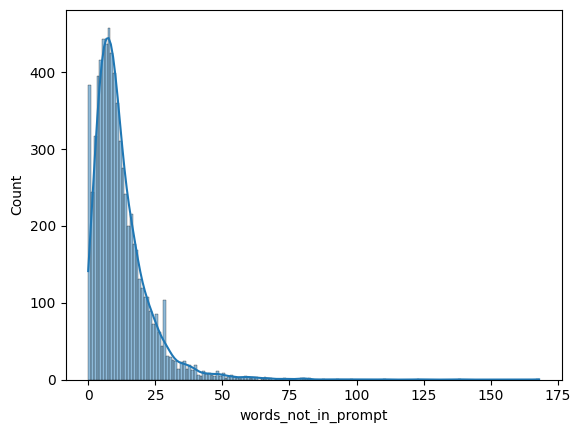

In [61]:
#we check the distribution of the words_not_in_prompt
sns.histplot(data=df_train_summaries, x='words_not_in_prompt', kde=True)

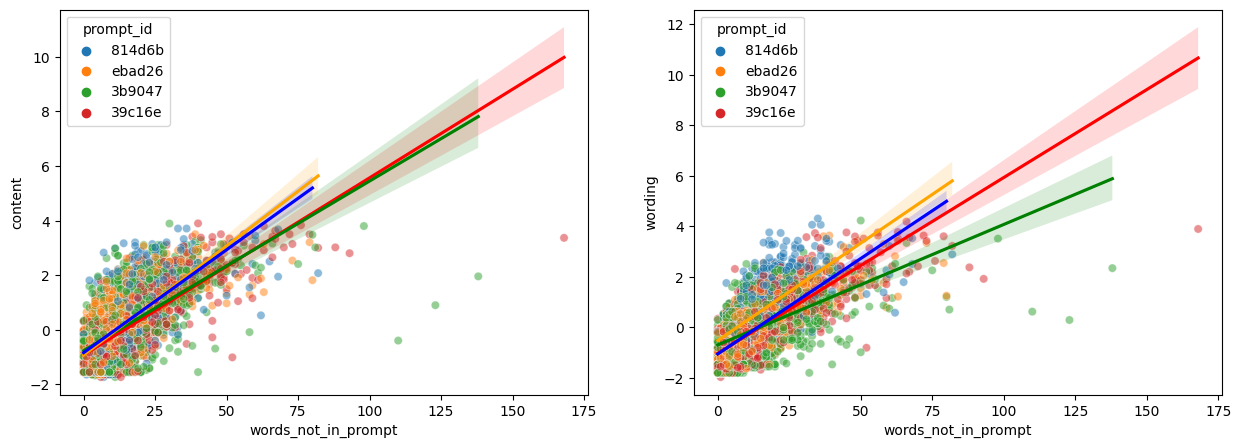

In [62]:
#we check for correlation between the words_not_in_prompt and the targets
plot_feature_corr(df_train_summaries, 'words_not_in_prompt')

In [63]:
#we transform the words_not_in_prompt as the root of the number of words not in the prompt
df_train_summaries['words_not_in_prompt_root'] = df_train_summaries['words_not_in_prompt'].apply(lambda x: math.sqrt(x))

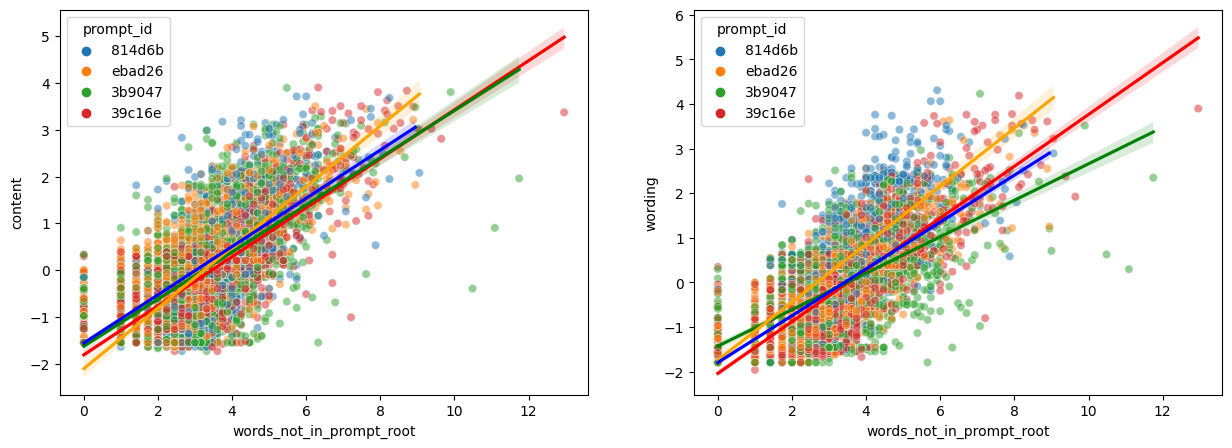

In [64]:
#we check for correlation between the words_not_in_prompt_root and the targets
plot_feature_corr(df_train_summaries, 'words_not_in_prompt_root')   

# Accessing the relative abundance of tags 4grams TfIdfCountvertorizer

In [65]:
#We create a function that remove spaces from the 'text_ngrams'
def remove_spaces(text_ngrams):
    ngrams_list_string = []
    for sentence in text_ngrams:
        ngrams_list_string.append(''.join([word for word in list(sentence) if word != ' ']))
    return ' '.join(ngrams_list_string)

In [66]:
df_train_summaries['text_4grams_string'] = df_train_summaries['text_4grams'].apply(lambda x: remove_spaces(x))

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from the text_bigrams_string, text_trigrams_string, text_4grams_string, text_5grams_string we create tfidf
def create_tfidf(text_ngrams_string, df_train_summaries):    
    #we create an instance of TfidfVectorizer
    vectorizer = TfidfVectorizer()
    #we fit the vectorizer to the text_bigrams_string
    X = vectorizer.fit(df_train_summaries[text_ngrams_string])
    #we transform the text_bigrams_string to tfidf
    X = vectorizer.transform(df_train_summaries[text_ngrams_string])
    #we create a dataframe with the tfidf
    df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    #we add the contetn and wording columns of df_train_summaries to the tfidf dataframe
    df_tfidf['content'] = df_train_summaries['content']
    df_tfidf['wording'] = df_train_summaries['wording']
    return df_tfidf

#we apply the function to the df_train_summaries dataframe for bigrams, trigrams, 4-grams and 5-grams
#df_tfidf_bigrams = create_tfidf('text_bigrams_string', df_train_summaries)
#df_tfidf_trigrams = create_tfidf('text_trigrams_string', df_train_summaries)
df_tfidf_4grams = create_tfidf('text_4grams_string', df_train_summaries)
#df_tfidf_5grams = create_tfidf('text_5grams_string', df_train_summaries)


In [68]:
#create a function that check the correlation between the tfidf and the targets (content, wording) and 
#return the columns with a correlation higher than 0.1 for either content or wording
def check_corr_tfidf(df_tfidf, threshold):
    list_columns = []
    for col in df_tfidf.columns:
        if col not in ['content', 'wording']:
            if abs(df_tfidf[col].corr(df_tfidf['content'])) > threshold or abs(df_tfidf[col].corr(df_tfidf['wording'])) > threshold:
                list_columns.append(col)
    return list_columns

In [69]:
#we apply the check_corr_tfidf function to the df_tfidf_bigrams dataframe
'''list_columns = []
list_columns = check_corr_tfidf(df_tfidf_bigrams, 0.2)
print(list_columns)'''


'list_columns = []\nlist_columns = check_corr_tfidf(df_tfidf_bigrams, 0.2)\nprint(list_columns)'

In [70]:
#we apply the check_corr_tfidf function to the df_tfidf_trigrams dataframe
'''list_columns = []
list_columns = check_corr_tfidf(df_tfidf_trigrams, 0.2)
print(list_columns)'''

#we add the columns found to the df_train_summaries dataframe
#df_train_summaries = pd.concat([df_train_summaries, df_tfidf_trigrams[list_columns]], axis=1)

'list_columns = []\nlist_columns = check_corr_tfidf(df_tfidf_trigrams, 0.2)\nprint(list_columns)'

In [71]:
#we apply the check_corr_tfidf function to the df_tfidf_4grams dataframe
list_columns = []
list_columns = check_corr_tfidf(df_tfidf_4grams, 0.1)
print(list_columns)

#we add the columns found to the df_train_summaries dataframe
df_train_summaries = pd.concat([df_train_summaries, df_tfidf_4grams[list_columns]], axis=1)

['cc', 'ccnns', 'ccnnsinjj', 'dt', 'dtjjnnin', 'dtnn', 'dtnnindt', 'dtnnnns', 'dtnns', 'dtnnsccnns', 'dtnnstodt', 'dtnnsvbdrb', 'dtnntonn', 'dtnnvbdrb', 'in', 'indt', 'indtjjnn', 'indtnn', 'indtnnin', 'indtnns', 'injjdtjj', 'innn', 'innns', 'inprp', 'invbgdtnns', 'jj', 'jjinvbgdt', 'jjnnindt', 'jjnninnn', 'nn', 'nnin', 'nnindtnn', 'nnindtnns', 'nnnnccnn', 'nnnns', 'nnnnscc', 'nnnnsccnns', 'nnnnswdtnn', 'nnprprbin', 'nns', 'nnsccnnsin', 'nnsinjjnn', 'nnsvbd', 'nnsvbddtnns', 'nnsvbdjjin', 'nnsvbdrbvbn', 'nnsvbn', 'nnswdtnnnn', 'nntodtnn', 'nnvbz', 'prp', 'prpnns', 'prprbinnn', 'prpvbdvbgin', 'rb', 'rbvbnindt', 'vbd', 'vbdjjinvbg', 'vbdnnsccnns', 'vbdtonndt', 'vbdvbginin', 'vbdvbntonn', 'vbg', 'vbgininnn', 'vbn', 'vbndtnnin', 'vbnindtnn', 'vbnnns', 'vbz', 'wdt', 'wdtnnnncc']


In [72]:
#we apply the check_corr_tfidf function to the df_tfidf_5grams dataframe
'''list_columns = []
list_columns = check_corr_tfidf(df_tfidf_5grams, 0.1)
print(list_columns)'''

'list_columns = []\nlist_columns = check_corr_tfidf(df_tfidf_5grams, 0.1)\nprint(list_columns)'

In [73]:
#we create a list of columns to drop from the df_tfidf_4grams dataframe
'''list_columns_to_drop = []
for col in df_tfidf_4grams.columns:
    if col not in list_columns:
        list_columns_to_drop.append(col)'''

'list_columns_to_drop = []\nfor col in df_tfidf_4grams.columns:\n    if col not in list_columns:\n        list_columns_to_drop.append(col)'

In [74]:
df_train_summaries.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording', 'text_length',
       'text_stopword_cnt_relative', 'text_punct_cnt_relative',
       'prompt_length', 'summary_prompt_ratio', 'text_cleaned',
       'text_sentences', 'text_tags', 'text_sentences_tags', 'text_4grams',
       'Jaccard_prompt_to_text', 'Jaccard_question_to_text',
       'shannon_diversity_index', 'shannon_diversity_index_exp',
       'words_not_in_prompt', 'list_words_not_in_prompt',
       'words_not_in_prompt_root', 'text_4grams_string', 'cc', 'ccnns',
       'ccnnsinjj', 'dt', 'dtjjnnin', 'dtnn', 'dtnnindt', 'dtnnnns', 'dtnns',
       'dtnnsccnns', 'dtnnstodt', 'dtnnsvbdrb', 'dtnntonn', 'dtnnvbdrb', 'in',
       'indt', 'indtjjnn', 'indtnn', 'indtnnin', 'indtnns', 'injjdtjj', 'innn',
       'innns', 'inprp', 'invbgdtnns', 'jj', 'jjinvbgdt', 'jjnnindt',
       'jjnninnn', 'nn', 'nnin', 'nnindtnn', 'nnindtnns', 'nnnnccnn', 'nnnns',
       'nnnnscc', 'nnnnsccnns', 'nnnnswdtnn', 'nnprprbin', 'nns', 'nnsccnns

# Check Point

In [75]:
#df_train_summaries.to_csv('df_train_summaries.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_csv('df_train_summaries.csv')

In [2]:
df.head(5)

,student_id,prompt_id,text,content,wording,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio,...,vbdvbntonn,vbg,vbgininnn,vbn,vbndtnnin,vbnindtnn,vbnnns,vbz,wdt,wdtnnnncc
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346,0.409836,0.049180,3566,0.097027,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,244,0.576923,0.038462,5136,0.047508,...,0.0,0.0,0.0,0.000000,0.000000,0.068499,0.0,0.0,0.00000,0.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1370,0.417021,0.161702,3345,0.409567,...,0.0,0.0,0.0,0.087783,0.042716,0.000000,0.0,0.0,0.00000,0.0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,157,0.440000,0.240000,3345,0.046936,...,0.0,0.0,0.0,0.000000,0.151972,0.000000,0.0,0.0,0.00000,0.0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225,0.446602,0.145631,3566,0.343522,...,0.0,0.0,0.0,0.034451,0.050292,0.032165,0.0,0.0,0.05224,0.0


In [3]:
df.columns 

Index(['student_id', 'prompt_id', 'text', 'content', 'wording', 'text_length',
       'text_stopword_cnt_relative', 'text_punct_cnt_relative',
       'prompt_length', 'summary_prompt_ratio', 'text_cleaned',
       'text_sentences', 'text_tags', 'text_sentences_tags', 'text_4grams',
       'Jaccard_prompt_to_text', 'Jaccard_question_to_text',
       'shannon_diversity_index', 'shannon_diversity_index_exp',
       'words_not_in_prompt', 'list_words_not_in_prompt',
       'words_not_in_prompt_root', 'text_4grams_string', 'cc', 'ccnns',
       'ccnnsinjj', 'dt', 'dtjjnnin', 'dtnn', 'dtnnindt', 'dtnnnns', 'dtnns',
       'dtnnsccnns', 'dtnnstodt', 'dtnnsvbdrb', 'dtnntonn', 'dtnnvbdrb', 'in',
       'indt', 'indtjjnn', 'indtnn', 'indtnnin', 'indtnns', 'injjdtjj', 'innn',
       'innns', 'inprp', 'invbgdtnns', 'jj', 'jjinvbgdt', 'jjnnindt',
       'jjnninnn', 'nn', 'nnin', 'nnindtnn', 'nnindtnns', 'nnnnccnn', 'nnnns',
       'nnnnscc', 'nnnnsccnns', 'nnnnswdtnn', 'nnprprbin', 'nns', 'nnsccnns

# Creating the training and test dataset 

In [4]:
X = df[['text_length',
       'text_stopword_cnt_relative', 'text_punct_cnt_relative',
       'prompt_length', 'summary_prompt_ratio',
       'Jaccard_prompt_to_text', 'Jaccard_question_to_text',
       'shannon_diversity_index_exp',
       'words_not_in_prompt_root', 'cc', 'ccnns',
       'ccnnsinjj', 'dt', 'dtjjnnin', 'dtnn', 'dtnnindt', 'dtnnnns', 'dtnns',
       'dtnnsccnns', 'dtnnstodt', 'dtnnsvbdrb', 'dtnntonn', 'dtnnvbdrb', 'in',
       'indt', 'indtjjnn', 'indtnn', 'indtnnin', 'indtnns', 'injjdtjj', 'innn',
       'innns', 'inprp', 'invbgdtnns', 'jj', 'jjinvbgdt', 'jjnnindt',
       'jjnninnn', 'nn', 'nnin', 'nnindtnn', 'nnindtnns', 'nnnnccnn', 'nnnns',
       'nnnnscc', 'nnnnsccnns', 'nnnnswdtnn', 'nnprprbin', 'nns', 'nnsccnnsin',
       'nnsinjjnn', 'nnsvbd', 'nnsvbddtnns', 'nnsvbdjjin', 'nnsvbdrbvbn',
       'nnsvbn', 'nnswdtnnnn', 'nntodtnn', 'nnvbz', 'prp', 'prpnns',
       'prprbinnn', 'prpvbdvbgin', 'rb', 'rbvbnindt', 'vbd', 'vbdjjinvbg',
       'vbdnnsccnns', 'vbdtonndt', 'vbdvbginin', 'vbdvbntonn', 'vbg',
       'vbgininnn', 'vbn', 'vbndtnnin', 'vbnindtnn', 'vbnnns', 'vbz', 'wdt',
       'wdtnnnncc']]

Y = df[['content', 'wording']]

Now let us split the dataset into training and testing datasets:

In [5]:
'''def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(preprocessed_df)
train_ds_pd.shape, valid_ds_pd.shape'''

#sklearn library train_test_split function can be used instead of the above function
#in addition, the random_state parameter can be used to ensure that the same split is made each time
#as well as the stratify parameter to ensure that the distribution of the target variable is the same in the train and validation sets
#as weel as the schuffle parameter to ensure that the data is shuffled before splitting
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_train.shape,  X_test.shape, Y_train.shape, Y_test.shape

((5015, 80), (2150, 80), (5015, 2), (2150, 2))

### Let's check the distribution of all features in the train and validation dataset

In [6]:
#plot the distribution of the feature in the train and test set
def plot_feature_distribution(X_train, X_test):
    #set plt.figure to define the size of the plot using 5 figure per row and accomodate all the features
    plt.figure(figsize=(20, 60))
    #iterate over the columns of the dataframe
    for i, col in enumerate(X_train.columns):
        #create a subplot for each feature
        plt.subplot(int(len(X_train.columns)/5), 5, i+1)
        #plot the histogram of the feature
        sns.histplot(X_train[col], kde=True, color='blue', label='train', alpha=0.6)
        sns.histplot(X_test[col], kde=True, color='red', label='test', alpha=0.6)
        plt.legend()
        plt.title(col)
        plt.xlabel('')
        plt.ylabel('')

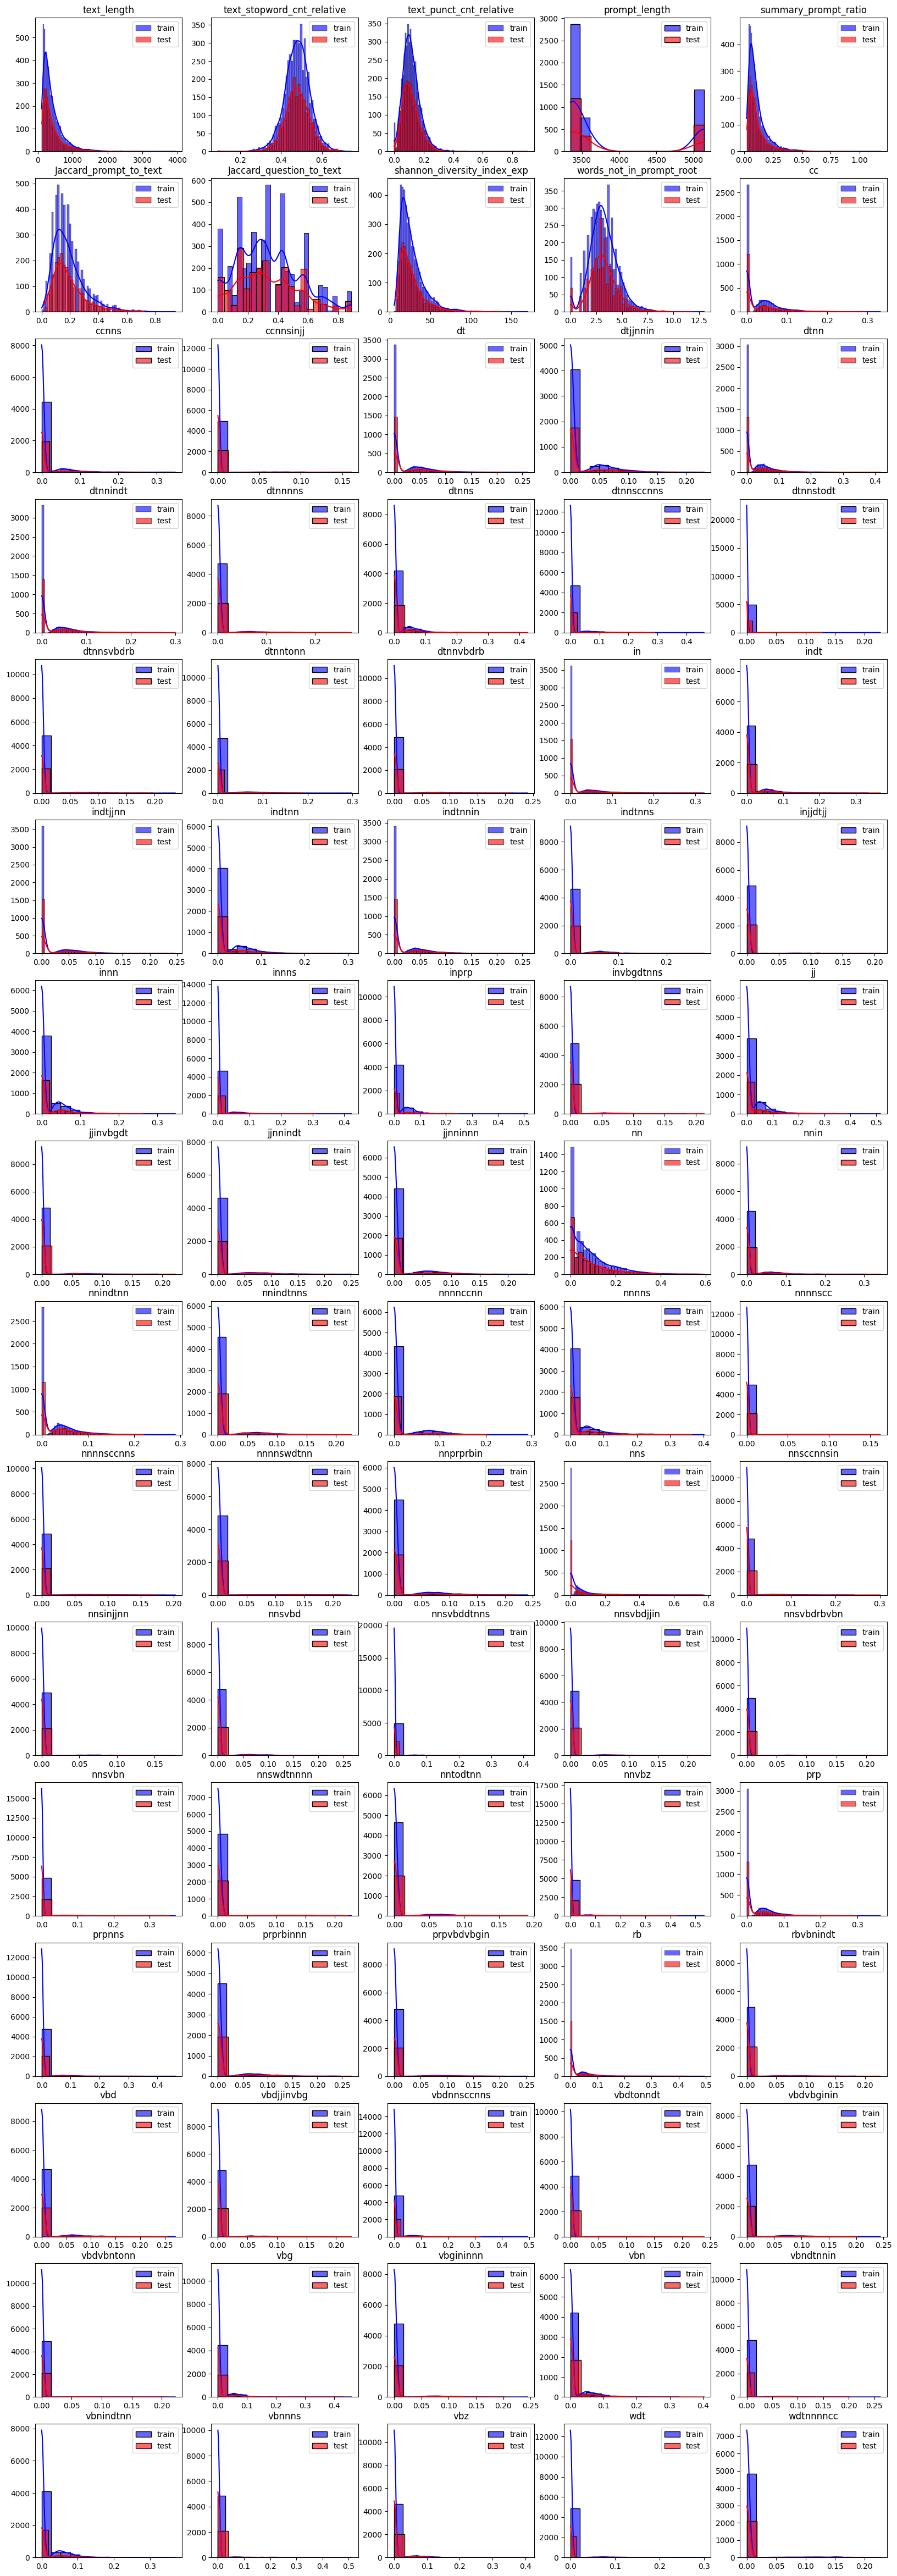

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
plot_feature_distribution(X_train, X_test)

In [25]:
X_train.columns

Index(['text_length', 'text_stopword_cnt_relative', 'text_punct_cnt_relative',
       'prompt_length', 'summary_prompt_ratio', 'Jaccard_prompt_to_text',
       'Jaccard_question_to_text', 'shannon_diversity_index_exp',
       'words_not_in_prompt_root', 'cc', 'ccnns', 'ccnnsinjj', 'dt',
       'dtjjnnin', 'dtnn', 'dtnnindt', 'dtnnnns', 'dtnns', 'dtnnsccnns',
       'dtnnstodt', 'dtnnsvbdrb', 'dtnntonn', 'dtnnvbdrb', 'in', 'indt',
       'indtjjnn', 'indtnn', 'indtnnin', 'indtnns', 'injjdtjj', 'innn',
       'innns', 'inprp', 'invbgdtnns', 'jj', 'jjinvbgdt', 'jjnnindt',
       'jjnninnn', 'nn', 'nnin', 'nnindtnn', 'nnindtnns', 'nnnnccnn', 'nnnns',
       'nnnnscc', 'nnnnsccnns', 'nnnnswdtnn', 'nnprprbin', 'nns', 'nnsccnnsin',
       'nnsinjjnn', 'nnsvbd', 'nnsvbddtnns', 'nnsvbdjjin', 'nnsvbdrbvbn',
       'nnsvbn', 'nnswdtnnnn', 'nntodtnn', 'nnvbz', 'prp', 'prpnns',
       'prprbinnn', 'prpvbdvbgin', 'rb', 'rbvbnindt', 'vbd', 'vbdjjinvbg',
       'vbdnnsccnns', 'vbdtonndt', 'vbdvbginin'

In [26]:
X_train

,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio,Jaccard_prompt_to_text,Jaccard_question_to_text,shannon_diversity_index_exp,words_not_in_prompt_root,cc,...,vbdvbntonn,vbg,vbgininnn,vbn,vbndtnnin,vbnindtnn,vbnnns,vbz,wdt,wdtnnnncc
6807,545,0.450980,0.107843,3566,0.152832,0.18,0.222222,37.384911,4.898979,0.000000,...,0.0,0.000000,0.068094,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5227,150,0.500000,0.107143,3364,0.044590,0.12,0.428571,10.690785,2.000000,0.082537,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
2722,176,0.513514,0.027027,3364,0.052319,0.06,0.285714,16.000000,3.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5777,158,0.518519,0.037037,5136,0.030763,0.14,0.166667,13.000000,1.414214,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
108,241,0.454545,0.181818,3364,0.071641,0.18,0.285714,23.000000,2.828427,0.099692,...,0.0,0.089647,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,203,0.552632,0.078947,3345,0.060688,0.12,0.200000,15.668724,2.236068,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5191,198,0.536585,0.073171,5136,0.038551,0.14,0.166667,16.420216,0.000000,0.142429,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5226,923,0.488372,0.156977,5136,0.179712,0.28,0.333333,54.282152,4.690416,0.116095,...,0.0,0.000000,0.000000,0.074464,0.0,0.00000,0.057736,0.047749,0.056457,0.0
5390,417,0.545455,0.090909,3364,0.123960,0.22,0.428571,24.162068,4.000000,0.040482,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0


# Model 

Let's fit a XGBregressor on the 'content' target

In [10]:
Y_train_content = Y_train[['content']]
Y_test_content = Y_test[['content']]

In [11]:
X_train

,text_length,text_stopword_cnt_relative,text_punct_cnt_relative,prompt_length,summary_prompt_ratio,Jaccard_prompt_to_text,Jaccard_question_to_text,shannon_diversity_index_exp,words_not_in_prompt_root,cc,...,vbdvbntonn,vbg,vbgininnn,vbn,vbndtnnin,vbnindtnn,vbnnns,vbz,wdt,wdtnnnncc
6807,545,0.450980,0.107843,3566,0.152832,0.18,0.222222,37.384911,4.898979,0.000000,...,0.0,0.000000,0.068094,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5227,150,0.500000,0.107143,3364,0.044590,0.12,0.428571,10.690785,2.000000,0.082537,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
2722,176,0.513514,0.027027,3364,0.052319,0.06,0.285714,16.000000,3.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5777,158,0.518519,0.037037,5136,0.030763,0.14,0.166667,13.000000,1.414214,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
108,241,0.454545,0.181818,3364,0.071641,0.18,0.285714,23.000000,2.828427,0.099692,...,0.0,0.089647,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,203,0.552632,0.078947,3345,0.060688,0.12,0.200000,15.668724,2.236068,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5191,198,0.536585,0.073171,5136,0.038551,0.14,0.166667,16.420216,0.000000,0.142429,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0
5226,923,0.488372,0.156977,5136,0.179712,0.28,0.333333,54.282152,4.690416,0.116095,...,0.0,0.000000,0.000000,0.074464,0.0,0.00000,0.057736,0.047749,0.056457,0.0
5390,417,0.545455,0.090909,3364,0.123960,0.22,0.428571,24.162068,4.000000,0.040482,...,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.0


In [30]:
#import XGBRegressor
from xgboost import XGBRegressor
#import crossvalidation gridsearch
from sklearn.model_selection import GridSearchCV
#we create an instance of XGBRegressor
xgb_model = XGBRegressor()
parameters = {'max_depth': [2,4,6], 'n_estimators': [50,100,200], 'learning_rate': [0.05, 0.1, 0.2], 'reg_lambda' : [0.1, 0.5, 1]}
model_content = GridSearchCV(xgb_model, parameters, cv = 10, verbose=1)
#we fit the model to the train dataset
model_content.fit(X_train, Y_train_content)
#we predict the target variables for the test dataset
Y_pred = model_content.predict(X_test)
#we calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(Y_test_content, Y_pred))
print(rmse)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
0.45119516931884873


In [31]:
Y_pred = model_content.predict(X_test)

In [32]:
#show the best parameters
model_content.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 1}

In [33]:
model_content.best_score_

0.8089479965899027

In [34]:
#calculate the R2 score on the test dataset
from sklearn.metrics import r2_score
r2_score(Y_test_content, Y_pred)

0.8187334629044286

Let's do the same on the 'wording' target

In [35]:
Y_train_wording = Y_train[['wording']]
Y_test_wording = Y_test[['wording']]

#import XGBRegressor
from xgboost import XGBRegressor
#import crossvalidation gridsearch
from sklearn.model_selection import GridSearchCV
#we create an instance of XGBRegressor
xgb_model = XGBRegressor()
parameters = {'max_depth': [2,4,6], 'n_estimators': [50,100,200], 'learning_rate': [0.05, 0.1, 0.2], 'reg_lambda' : [0.1, 0.5, 1]}
model_wording = GridSearchCV(xgb_model, parameters, cv = 10, verbose=1)
#we fit the model to the train dataset
model_wording.fit(X_train, Y_train_wording)
#we predict the target variables for the test dataset
Y_pred = model_wording.predict(X_test)
#we calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(Y_test_wording, Y_pred))
print(rmse)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


0.6072742242981145


In [36]:
#show the best parameters
model_wording.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1}

In [37]:
#show the best score
model_wording.best_score_

0.6431384771425167

In [38]:
#calculate the R2 score on the test dataset
from sklearn.metrics import r2_score
r2_score(Y_test_wording, Y_pred)

0.6522138476498491

In [39]:
#get the rmse for the content and wording on the test dataset
Y_pred_content = model_content.predict(X_test)
Y_pred_wording = model_wording.predict(X_test)
rmse_content = sqrt(mean_squared_error(Y_test_content, Y_pred_content))
rmse_wording = sqrt(mean_squared_error(Y_test_wording, Y_pred_wording))
print(f'the rmse for the content is {rmse_content}')
print(f'the rmse for the wording is {rmse_wording}')

the rmse for the content is 0.45119516931884873
the rmse for the wording is 0.6072742242981145


 # Conclusion